# Cheaters demise code

The previous code defined the clusters of suspicious users, which were characterized as those who didn't watch (almost) any videos and documents and got all the answers right. These are thought to be users who deal with fake and real accounts, counting errors on the fakes and taking the right answers on the real ones.

Since there is a defined cluster of suspicious users, the following code will try to identify the activity of these users and see if they can be considered as cheaters or not, depending on timing and improvement. By taking into account that timing would be equal to the time difference between an answer from one user and the other, there may be a correlation between them, since after finding the real answer on a fake account, the user would input it into his real account in a short period. Also, improvement is a metric that can differentiate between a user that coincidently did it right after another and a cheater, by measuring if the user got the wrong answer or not. If it did get the wrong answer, than he's not using a fake account.

One course of action is to create a graph of exercise (i) by user(j) and the time it took the user to finish it.

## Clear environment

In [145]:
%reset -f

In [146]:
%matplotlib inline

 # Import all definitions and libraries

In [147]:
import importlib
import Definitions

importlib.reload(Definitions)

from Definitions import *

Libraries and definitions loaded correctly.


# Read scores and user data

In [148]:
df = readDataFile("eventos_final.json")
scores_csv = pd.read_csv("UAMx_Android301x_1T2015_grade_report_2015-04-21-1145_sanitized.csv")
ids_sospechosos = pd.read_csv("UserIDClusterSospechoso.csv")

In [149]:
N_USERS = len(df.Usuario)

# create the exercise listt`
correctExercises = np.empty((N_USERS, N_EXERCISES))
correctExercises.fill(np.nan)

correctExercisesCount = np.empty(N_USERS)
correctExercisesCount.fill(0)

wrongExercises = np.empty((N_USERS, N_EXERCISES))
wrongExercises.fill(np.nan)

wrongExercisesCount = np.empty(N_USERS)
wrongExercisesCount.fill(0)

scores = []

print("Logging scores...")

for i in range(1, len(df.Usuario)):
    try:
        score = scores_csv.loc[scores_csv['id'] == int(df.Usuario[i])]['grade'].item()
        scores.append((int(df.Usuario[i]), score))
    except:                      
        scores.append((int(df.Usuario[i]), np.nan))

    #clear()
    #print('Scores:', math.ceil(i*100/len(df.Usuario)), '% done')

print("Finished logging scores.")
print("Logging exercises...")

for i in range(0, len(df.Usuario)):
    for j in range(0, len(df.Eventos[i])):
        if (df.Eventos[i][j]['evento'] == 'problem_check'):
            #print('\t problem_check')
            if (df.Eventos[i][j]['resultados'] != []):
                #print('\t \t results')
                # convert date time to epoch time for a better comparison
                time_split = df.Eventos[i][j]['tiempo'].split('T')
                time_tuple = time.strptime(time_split[0] + ' ' + time_split[1][:8], date_format)
                time_epoch = time.mktime(time_tuple)   
                if(df.Eventos[i][j]['resultados'][0]['correcto'] == 'True'):
                    #print('\t \t \t right')
                    correctExercises[i][int(df.Eventos[i][j]['id_problema']) - 1] = time_epoch
                    correctExercisesCount[i] = correctExercisesCount[i] + 1
                elif(df.Eventos[i][j]['resultados'][0]['correcto'] == 'False'):
                    #print('\t \t \t wrong')
                    wrongExercises[i][int(df.Eventos[i][j]['id_problema']) - 1] = time_epoch
                    num_intentos = int(df.Eventos[i][j]['num_intentos'])
                    wrongExercisesCount[i] = (wrongExercisesCount[i] - num_intentos + 1) + num_intentos
    #clear()
    #print('Exercises:', math.ceil(i*100/N_USERS), '% done')

print('Ended logging.')

N_USERS = len(df)

Logging scores...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: `item` has been deprecated and will be removed in a future version


Finished logging scores.
Logging exercises...
Ended logging.


## Cutting down the size of the arrays

In [150]:
# Cutting down the size of the arrays

print(df.shape, correctExercises.shape, wrongExercises.shape)

users_to_delete = []

for i in range(0, N_USERS):
    nbr_attempts = wrongExercisesCount[i] + correctExercisesCount[i]
    if (nbr_attempts < MIN_EXERCISES):
        df = df.drop([i])
        users_to_delete.append(i)

correctExercises = np.delete(correctExercises, users_to_delete, 0)
wrongExercises = np.delete(wrongExercises, users_to_delete, 0)
correctExercisesCount = np.delete(correctExercisesCount, users_to_delete, 0)
wrongExercisesCount = np.delete(wrongExercisesCount, users_to_delete, 0)

df = df.reset_index(drop=True)

print(df.shape, correctExercises.shape, wrongExercises.shape)

(7171, 2) (7171, 196) (7171, 196)
(2087, 2) (2087, 196) (2087, 196)


In [151]:
N_USERS = len(df.Usuario)

correctExercises_minutes = correctExercises / 60
wrongExercises_minutes = wrongExercises / 60

# Select users

In [152]:
dump_exists = os.path.isfile(str(tol) + '/' + str(tol) + '-' + str(MIN_EXERCISES) + '.csv')

if (dump_exists):
    df_all_selected_users = pd.read_csv(str(tol) + '/' + str(tol) + '-' + str(MIN_EXERCISES) + '.csv', index_col=0)
    df_all_selected_users.fillna('', inplace=True)

    selected_users_CC = literal_eval(df_all_selected_users.loc[0][0])
    selected_users_XC = literal_eval(df_all_selected_users.loc[1][0])
    selected_users_CX = literal_eval(df_all_selected_users.loc[2][0])
    selected_users_XX = literal_eval(df_all_selected_users.loc[3][0])
    
    print('Dump loaded.')
else:
    #if __name__ == '__main__':
        #__spec__ = None
        selected_users_CC = Manager().list()
        selected_users_XC = Manager().list()
        selected_users_CX = Manager().list()
        selected_users_XX = Manager().list()

        print('Selecting CC users...')
        p_CC = Process(target=selectUsers, args=(selected_users_CC, tol, correctExercises_minutes, correctExercises_minutes, 'CC', N_USERS, MIN_EXERCISES,))
        p_CC.start()
        print('Selecting XC users...')
        p_XC = Process(target=selectUsers, args=(selected_users_XC, tol, wrongExercises_minutes, correctExercises_minutes, 'XC', N_USERS, MIN_EXERCISES))
        p_XC.start()
        print('Selecting CX users...')
        p_CX = Process(target=selectUsers, args=(selected_users_CX, tol, correctExercises_minutes, wrongExercises_minutes, 'CX', N_USERS, MIN_EXERCISES))
        p_CX.start()
        print('Selecting XX users...')
        p_XX = Process(target=selectUsers, args=(selected_users_XX, tol, wrongExercises_minutes, wrongExercises_minutes, 'XX', N_USERS, MIN_EXERCISES))
        p_XX.start()

        p_CC.join()
        p_XC.join()
        p_CX.join()
        p_XX.join()

        df_all_selected_users = pd.DataFrame([selected_users_CC, selected_users_XC, selected_users_CX, selected_users_XX])
        df_all_selected_users.to_csv(str(tol) + '/' + str(tol) + '-' + str(MIN_EXERCISES) + '.csv')

        print("Data stored.")

Dump loaded.


# Calculate the time difference between the users

In [153]:
if __name__ == '__main__':
    __spec__ = None
    time_differences_CC = Manager().list()
    time_differences_XC = Manager().list()
    time_differences_CX = Manager().list()
    time_differences_XX = Manager().list()

    print('Time differentiating CC users...')
    p_CC = Process(target=ctd.computeTimeDifferences, args=(time_differences_CC, selected_users_CC, 
                                                        correctExercises_minutes, correctExercises_minutes, 'CC', N_EXERCISES,))
    p_CC.start()
    print('Time differentiating XC users...')
    p_XC = Process(target=ctd.computeTimeDifferences, args=(time_differences_XC, selected_users_XC,
                                                        wrongExercises_minutes, correctExercises_minutes, 'XC', N_EXERCISES,))
    p_XC.start()
    print('Time differentiating CX users...')
    p_CX = Process(target=ctd.computeTimeDifferences, args=(time_differences_CX, selected_users_CX,
                                                        correctExercises_minutes, wrongExercises_minutes, 'CX', N_EXERCISES,))
    p_CX.start()
    print('Time differentiating XX users...')
    p_XX = Process(target=ctd.computeTimeDifferences, args=(time_differences_XX, selected_users_XX,
                                                        wrongExercises_minutes, wrongExercises_minutes, 'XX', N_EXERCISES,))
    p_XX.start()

    p_CC.join()
    p_XC.join()
    p_CX.join()
    p_XX.join()
    
    print('Finished.')

Time differentiating CC users...
Time differentiating XC users...
Time differentiating CX users...
Time differentiating XX users...
XC finished.
CX finished.
XX finished.
CC finished.
Finished.


## Users in common

Finds which users are considered into the selection, without repetitions

In [154]:
users_in_common = []

for k in range(0, len(selected_users_CC)):
    if (selected_users_CC[k][0] not in users_in_common):
        users_in_common.append(selected_users_CC[k][0])
    if (selected_users_CC[k][1] not in users_in_common):
        users_in_common.append(selected_users_CC[k][1]) 

for l in range(0, len(selected_users_XC)):
    if (selected_users_XC[l][0] not in users_in_common):
        users_in_common.append(selected_users_XC[l][0])
    if (selected_users_XC[l][1] not in users_in_common):
        users_in_common.append(selected_users_XC[l][1])

for m in range(0, len(selected_users_CX)):
    if (selected_users_CX[m][0] not in users_in_common):
        users_in_common.append(selected_users_CX[m][0])
    if (selected_users_CX[m][1] not in users_in_common):
        users_in_common.append(selected_users_CX[m][1]) 

for n in range(0, len(selected_users_XX)):
    if (selected_users_XX[n][0] not in users_in_common):
        users_in_common.append(selected_users_XX[n][0])
    if (selected_users_XX[n][1] not in users_in_common):
        users_in_common.append(selected_users_XX[n][1])

print('\t Result size:', len(users_in_common))
print('\t Result data:', users_in_common)

	 Result size: 137
	 Result data: [2, 1262, 6, 1046, 14, 905, 27, 1918, 32, 815, 61, 1245, 67, 85, 356, 515, 575, 2036, 102, 1572, 126, 1594, 194, 1031, 1933, 205, 303, 208, 354, 214, 1972, 244, 732, 261, 1452, 266, 1751, 272, 2016, 293, 964, 308, 1334, 1748, 337, 1496, 392, 1915, 410, 413, 418, 1077, 419, 430, 2048, 580, 436, 621, 870, 455, 840, 456, 1068, 478, 1120, 1992, 486, 808, 496, 1087, 530, 595, 1733, 536, 1050, 546, 1388, 1583, 550, 576, 626, 2030, 659, 1912, 677, 1203, 702, 1225, 705, 1247, 726, 731, 792, 1064, 872, 1655, 924, 1390, 950, 1609, 957, 1836, 1155, 1453, 1156, 1162, 1422, 1194, 1791, 1210, 2055, 1239, 1498, 1252, 1518, 1301, 1620, 1336, 1349, 1427, 1672, 1548, 1766, 1703, 1725, 1803, 273, 1830, 407, 839, 630, 2033, 1332, 1485, 1076, 803, 1060]


# Join type arrays

In [155]:
label = []
all_selected_users = []
all_time_differences = []

versions = ['CC', 'XC', 'CX', 'XX']
temp_users = [list(selected_users_CC), list(selected_users_XC), list(selected_users_CX), list(selected_users_XX)]
temp_td = [list(time_differences_CC), list(time_differences_XC), list(time_differences_CX), list(time_differences_XX)]
temp_size = [len(selected_users_CC), len(selected_users_XC), len(selected_users_CX), len(selected_users_XX)]

#for l in range(0, 4):        
#    z = temp_size.index(max(temp_size))
#    label.append(versions[z])
#    all_selected_users.append(temp_users[z])
#    all_time_differences.append(temp_td[z])
#    temp_size.pop(z) 
#    versions.pop(z) 
#    temp_users.pop(z)
#    temp_td.pop(z)

all_selected_users = temp_users
all_time_differences = temp_td
label = versions

print(label)
print(label[0], len(all_selected_users[0]), '||', len(selected_users_CC))
print(label[1], len(all_selected_users[1]), '||', len(selected_users_XC))
print(label[2], len(all_selected_users[2]), '||', len(selected_users_CX))
print(label[3], len(all_selected_users[3]), '||', len(selected_users_XX))

['CC', 'XC', 'CX', 'XX']
CC 80 || 80
XC 13 || 13
CX 13 || 13
XX 1 || 1


In [156]:
type_array = type_separation(all_selected_users, all_time_differences, tol)
print('Finished')

Finished


# Calculate user bias and pairs through the type arrays

In [157]:
user_pairs, user_score_difference, fig, string_dump, user_interaction_percentages = generate_pairs(type_array, df.Usuario, scores, trimming, label, plot=True)

with open('user_bias_dump.txt', 'w') as filehandle:
    json.dump(string_dump, filehandle)

print('Done.')
    
#print('Plotting', len(user_pairs), 'pairs consisted of', len(users_in_common), 'users')
#fig.set_size_inches(20, len(fig.axes) * 6)
#plt.savefig(str(tol) + '/' + str(trimming) + '-user_bias.png')
#plt.show()

Done.


## Distance matrix

In [158]:
matrix_size = len(users_in_common)

distance_matrix = np.ones((matrix_size, matrix_size))

for i in range(0, matrix_size):
    user_1 = users_in_common[i]
    for j in range(0, matrix_size):
        user_2 = users_in_common[j]
        for k in range(0, len(type_array)):
            if (type_array[k][0][0] == user_1 and type_array[k][0][1] == user_2):
                distance_matrix[i][j] = type_array[k][2]
                distance_matrix[j][i] = type_array[k][2]

distance_matrix = abs(distance_matrix)

for i in range(0, matrix_size):
    for j in range(0, matrix_size):
        if (i == j):
            distance_matrix[i][j] = 0

distance_matrix[np.isnan(distance_matrix)] = 1

#plt.figure(figsize=(15, 15))
#ax = sns.heatmap(distance_matrix, annot=True, annot_kws={"size": 7}, fmt = '.2f')

#ax.set(xticklabels=users_in_common, yticklabels=users_in_common)
#plt.show()

## Dendrogram

In [159]:
plt.figure(figsize=(60, 28))  

#print(np.shape(distance_matrix))

square = ssd.squareform(distance_matrix)

linkage = sch.linkage(square, method='single')

dend = sch.dendrogram(linkage, labels=users_in_common, leaf_rotation=90)

plt.title("Dendrogram", size=40)  
plt.xlabel('Users', size=40)
plt.ylabel('Distance', size=40)
plt.xticks(size = 20)
plt.yticks(size = 40)

plt.savefig(str(tol) + '/' + str(trimming) + '-dendrogram.png')

#plt.show()

# Process type array and eliminate users without a score

In [160]:
type_array = np.array(type_array)
user_score_difference = np.array(user_score_difference)

total_exercises_under_tol = type_array[:, 3]
type_array = np.reshape(type_array[:, 2], (-1, 1))
user_score_difference = np.reshape(user_score_difference, (-1, 1))

analysing_data = np.concatenate((type_array, user_score_difference), axis=1)

analysing_data = np.array(analysing_data, np.float)

user_pairs_copy = user_pairs.copy()

i = 0
while i < len(analysing_data):
    if(np.isnan(analysing_data[i,1])):
        user_pairs_copy.pop(i)
        user_interaction_percentages.pop(i)
        user_score_difference = np.delete(user_score_difference, i, 0)
        analysing_data = np.delete(analysing_data, i, 0)
        total_exercises_under_tol = np.delete(total_exercises_under_tol, i, 0)
    else:
        i = i + 1

print(len(user_pairs_copy), 'pairs remaining.')

77 pairs remaining.


## Plot the amout of exercise by user through the whole dataset

In [17]:
plt.figure(figsize=(10, 7))
plt.xlabel('User bias', fontsize=25)
plt.ylabel('Score difference', fontsize=25)
plt.title("Amount of exercises by user", fontsize=25)

scatter = plt.scatter(analysing_data[:, 0], analysing_data[:, 1], s=250, edgecolors = 'black', c=total_exercises_under_tol, cmap='binary')

plt.colorbar(scatter)

#for i, txt in enumerate(user_pairs_copy):
#    plt.annotate(txt, (analysing_data[i, 0], analysing_data[i, 1]))

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])
plt.xticks(fontsize=20)

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-amount_of_exercises.png', bbox_inches='tight')

#plt.show()

# Plot the distance from optimal curve (X^9) and separate outliers

In [18]:
plt.figure(figsize=(10, 7))
plt.xlabel('User bias')
plt.ylabel('Course final score difference between users')
plt.title("Distance from optimal curve (X^9)")

normal_points = []
outliers = []

for i, txt in enumerate(analysing_data):
    dist = distance(analysing_data[i, 0], analysing_data[i, 1])
    if (dist > 0.25):
        plt.annotate(round(dist, 2), (analysing_data[i, 0], analysing_data[i, 1])) 
        outliers.append([analysing_data[i, 0], analysing_data[i, 1], user_pairs_copy[i][0], user_pairs_copy[i][1]])
    else:
        normal_points.append([analysing_data[i, 0], analysing_data[i, 1], user_pairs_copy[i][0], user_pairs_copy[i][1]])

#for i, txt in enumerate(user_pairs_copy):
#    plt.annotate(txt, (analysing_data[i, 0], analysing_data[i, 1]))

normal_points = np.asarray(normal_points)
outliers = np.asarray(outliers)

plt.scatter(normal_points[:, 0], normal_points[:, 1], marker='o', color='blue', picker=True)   
plt.scatter(outliers[:, 0], outliers[:, 1], marker='o', color='red', picker=True)    

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-distance_from_curve.png')

#plt.show()

## Checking users: outliers or not

In [19]:
FLAG = 'both'

if (FLAG == 'outliers'):
    array_being_analysed = outliers
if (FLAG == 'normals'):
    array_being_analysed = normal_points
else:
    array_being_analysed = np.concatenate((normal_points, outliers), axis=0)

# Plot the hypotheses regions

In [20]:
first = []
second = []
third = []
fourth = []
fifth = []
others = []

plt.figure(figsize=(11, 7))
plt.xlabel('User bias', fontsize=25)
plt.ylabel('Score difference', fontsize=25)
plt.title("Hypotheses", fontsize=25)

for i in range(0, len(array_being_analysed)):
    d = array_being_analysed[i, 0]
    sc = array_being_analysed[i, 1]

    if (d >= 0.5 and sc >= 0.25):
        first.append([d, sc])
    elif (d >= 0.5 and sc > -0.25 and sc < 0.25):
        second.append([d, sc])
    elif (d > -0.5 and d < 0.5 and sc > -0.25 and sc < 0.25):
        third.append([d, sc])
    elif (d <= -0.5 and sc > -0.25 and sc < 0.25):
        fourth.append([d, sc])
    elif (d <= -0.5 and sc <= -0.25):
        fifth.append([d, sc])
    else:
        others.append([d, sc])

first = np.asarray(first)
second = np.asarray(second)
third = np.asarray(third)
fourth = np.asarray(fourth)
fifth = np.asarray(fifth)
others = np.asarray(others)

plt.scatter(first[:, 0], first[:, 1], marker='o', color='blue', s=250, picker=True)
plt.scatter(second[:, 0], second[:, 1], marker='o', color='black', s=250, picker=True)
plt.scatter(third[:, 0], third[:, 1], marker='o', color='black', s=250, picker=True)
plt.scatter(fourth[:, 0], fourth[:, 1], marker='o', color='black', s=250, picker=True)
plt.scatter(fifth[:, 0], fifth[:, 1], marker='o', color='orange', s=250, picker=True)
plt.scatter(others[:, 0], others[:, 1], marker='o', color='grey', s=250, picker=True)

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-hypotheses.png', bbox_inches='tight')

#plt.show()

In [21]:
ip_addrs = check_ip_addresses(array_being_analysed, df)

ips_in_common = []

for i in range(0, len(ip_addrs)):
    user_1_ips = ip_addrs[i][0]
    user_2_ips = ip_addrs[i][1]
    count_1 = ip_addrs[i][2]
    count_2 = ip_addrs[i][3]
    amount = 0
    for j in range(0, len(user_1_ips)):
        for k in range(0, len(user_2_ips)):
            if ((user_1_ips[j] == user_2_ips[k]) == True):
                amount = amount + min(count_1[j], count_2[k])
    #print('-'*100)
    #print('User 1 (', array_being_analysed[i][2], ',', len(user_1_ips), '): ', user_1_ips, count_1)
    #print('User 2 (', array_being_analysed[i][3], ',', len(user_2_ips), '): ', user_2_ips, count_2)
    #print('\nCorrelation: ', amount, np.intersect1d(user_1_ips, user_2_ips, assume_unique=True))
    ips_in_common.append(amount)

# Plot checked users

In [22]:
plt.figure(figsize=(10, 7))
plt.xlabel('User bias', fontsize=25)
plt.ylabel('Course final score difference between users', fontsize=25)
plt.title("Exercises with the same IP", fontsize=25)

scatter = plt.scatter(array_being_analysed[:, 0], array_being_analysed[:, 1], edgecolors = 'black', c=ips_in_common, cmap='binary')

plt.colorbar(scatter)

#for i, txt in enumerate(ips_in_common):
    #plt.annotate((txt, (array_being_analysed[i, 2], array_being_analysed[i, 3])), (array_being_analysed[i, 0], array_being_analysed[i, 1]))

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])
plt.xticks(fontsize=20)

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-exercises_same_ip-' + FLAG + '.png')

#plt.show()

# Calculate the material usage index

By counting the number of events a user has, it can measure how many of them were directed towards reading the materials. This is done by dividing the count of all the events by the count of the events where the user tried to solve an exercise. However, since a user can try the same exercise multiple times, it was decided that if the user tried the exercise at least one time (be it right or wrong), then it would count as a material usage towards that exercise and that's it, no additional tries for that exercise would be considered as material usage.

Therefore, the formula is: number_of_exercises_tried / (number_of_material_usages + number_of_exercises_tried).

The results mean: 
1 -> purely exercise tryouts (fake account); 

0,5 -> equal number of exercise tryouts and material reviews (legit user) and; 

0 -> purely material reviews (probably a professor or a material thief)

In [23]:
material_usage = check_material_usage(array_being_analysed, df)

In [24]:
plt.figure(figsize=(15, 8))
plt.xlabel('User bias', fontsize=25)
plt.ylabel('Score difference', fontsize=25)
plt.title("mMIR", fontsize=25)

material_usage_str = []

for i in range(0, len(material_usage)):
    material_usage_str.append(str(min(round(material_usage[i, 0], 2), round(material_usage[i, 1], 2))))

c_intensities = []

for i in range(0, len(array_being_analysed)):
    c_intensities.append(min(material_usage[i, 0], material_usage[i, 1]))
    
scatter = plt.scatter(array_being_analysed[:, 0], array_being_analysed[:, 1], s=250, edgecolors = 'black', c=c_intensities, cmap='binary')

plt.colorbar(scatter)

material_usage_dump = []

for i, txt in enumerate(material_usage_str):
    #plt.annotate((txt, (array_being_analysed[i, 2], array_being_analysed[i, 3])), (array_being_analysed[i, 0], array_being_analysed[i, 1]))
    material_usage_dump.append('User: ' + str(array_being_analysed[i, 2]) + ' User: ' + str(array_being_analysed[i, 3]) + ' ' + txt)

with open('material_usage_dump-' + FLAG + '.txt', 'w') as filehandle:
    json.dump(material_usage_dump, filehandle)

x = np.linspace(-1, 1, 201)
y = [pow(i, 9) for i in x]
plt.plot(x, y)

axes = plt.gca()
axes.set_xlim([-1.1, 1.1])
axes.set_ylim([-1.1, 1.1])
plt.xticks(fontsize=20)

plt.grid(color='grey', linestyle='--', linewidth=.5)

plt.savefig(str(tol) + '/' + str(trimming) + '-material_usage_index-' + FLAG + '.png', bbox_inches='tight')

#plt.show()

# Create a connection graph

In [25]:
ip_addrs_list = []

ip_addrs_list.append(check_ip_addresses(normal_points, df))
ip_addrs_list.append(check_ip_addresses(outliers, df))

temp = []

labels_ip_both = []

for h in range(0, 2):
    ip_addrs = ip_addrs_list[h]
    for i in range(0, len(ip_addrs)):
        user_1_ips = ip_addrs[i][0]
        user_2_ips = ip_addrs[i][1]
        count_1 = ip_addrs[i][2]
        count_2 = ip_addrs[i][3]
        amount = 0
        for j in range(0, len(user_1_ips)):
            for k in range(0, len(user_2_ips)):
                if ((user_1_ips[j] == user_2_ips[k]) == True):
                    amount = amount + min(count_1[j], count_2[k])
        #print('User 1 (', array_being_analysed[i][2], ',', len(user_1_ips), '): ', user_1_ips, count_1)
        #print('User 2 (', array_being_analysed[i][3], ',', len(user_2_ips), '): ', user_2_ips, count_2)
        #print('\nCorrelation: ', amount, np.intersect1d(user_1_ips, user_2_ips, assume_unique=True))
        temp.append('/' + str(len(user_1_ips)) + '/' + str(len(user_2_ips)) + '/' + str(len(np.intersect1d(user_1_ips, user_2_ips, assume_unique=True))))
    labels_ip_both.append(temp)
    
G = nx.DiGraph()

user_bias_array = analysing_data[:, 0]

labels_ip = []
i = 0

material_usage = []
material_usage_both = []
material_usage_both.append(check_material_usage(normal_points, df))
material_usage_both.append(check_material_usage(outliers, df))  

while i < len(user_pairs_copy):
    user_1 = int(user_pairs_copy[i][0])
    user_2 = int(user_pairs_copy[i][1])
    found = False

    for j in range(0, len(normal_points)):
        if (user_1 == normal_points[j][2] and user_2 == normal_points[j][3]):
            labels_ip.append(labels_ip_both[0][j])
            material_usage.append(material_usage_both[0][j])
            found = True
            i = i + 1
            break

    if (not found):   
        for k in range(0, len(outliers)):
            if (user_1 == outliers[k][2] and user_2 == outliers[k][3]):
                labels_ip.append(labels_ip_both[1][k])
                material_usage.append(material_usage_both[1][k])
                i = i + 1
                break

node_colors = {}

for i in range(0, len(material_usage)):           
    user_1 = int(user_pairs_copy[i][0])
    user_2 = int(user_pairs_copy[i][1])
    if (material_usage[i][0] == 0):
        node_colors[user_1] = 'red'
    else:
        node_colors[user_1] = 'blue'
    if (material_usage[i][1] == 0):
        node_colors[user_2] = 'red'
    else:
        node_colors[user_2] = 'blue'

node_color_array = []

labels = {}

for i in range(0, len(user_pairs_copy)):
    user_1 = int(user_pairs_copy[i][0])
    user_2 = int(user_pairs_copy[i][1])
    G.add_node(user_1)
    G.add_node(user_2)

    temp = abs(round(user_bias_array[i], 2))

    if (user_bias_array[i] >= 0):
        G.add_edge(user_1, user_2, width=temp * 10)
        labels[user_1, user_2] = str(temp) + str(labels_ip[i])
    else:
        G.add_edge(user_2, user_1, width=temp * 10)
        labels[user_2, user_1] = str(temp) + str(labels_ip[i])

for node in G:
    node_color_array.append(node_colors[node])

pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args="-Gnodesep=5")

# Plot connection graph

In [26]:
plt.close('all')

In [27]:
plt.figure(figsize=(50, 50))

width = [G[u][v]['width'] for u,v in G.edges()]      

nx.draw(G, pos, node_color=node_color_array)

nx.draw_networkx_edges(G, pos, width=width)

nx.draw_networkx_labels(G, pos, font_size=10)

text = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

for _,t in text.items():
    t.set_rotation('vertical')

plt.savefig(str(tol) + '/' + str(trimming) + '-connection-graph' + '.png')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


# Clustering

In [28]:
temp = []

for i, txt in enumerate(analysing_data):
    temp.append([analysing_data[i, 0], analysing_data[i, 1], user_pairs_copy[i][0], user_pairs_copy[i][1]])

ip_addrs_temp = check_ip_addresses(temp, df)

ips_in_common_temp = []

for i in range(0, len(ip_addrs_temp)):
    user_1_ips = ip_addrs_temp[i][0]
    user_2_ips = ip_addrs_temp[i][1]
    amount = 0
    for j in range(0, len(user_1_ips)):
        for k in range(0, len(user_2_ips)):
            if (user_1_ips[j] == user_2_ips[k]):
                amount = amount + 1
    print('Total:', len(user_1_ips), len(user_2_ips), amount)
    #print('-'*100)
    #print('User 1 (', array_being_analysed[i][2], ',', len(user_1_ips), '): ', user_1_ips, count_1)
    #print('User 2 (', array_being_analysed[i][3], ',', len(user_2_ips), '): ', user_2_ips, count_2)
    #print('\nCorrelation: ', amount, np.intersect1d(user_1_ips, user_2_ips, assume_unique=True))
    total = len(user_1_ips) + len(user_2_ips)
    ips_in_common_temp.append(amount / (total - amount))

Total: 3 7 2
Total: 1 5 1
Total: 1 1 1
Total: 1 7 1
Total: 1 9 1
Total: 4 4 4
Total: 2 2 2
Total: 4 1 0
Total: 4 1 0
Total: 1 18 1
Total: 1 2 1
Total: 4 7 3
Total: 4 3 3
Total: 5 9 3
Total: 10 3 3
Total: 10 4 1
Total: 3 3 2
Total: 6 1 1
Total: 5 3 3
Total: 2 1 1
Total: 10 4 0
Total: 7 3 3
Total: 3 4 1
Total: 4 4 0
Total: 8 18 1
Total: 13 18 10
Total: 2 2 2
Total: 2 3 1
Total: 8 7 7
Total: 3 5 3
Total: 1 3 1
Total: 4 2 2
Total: 4 3 3
Total: 1 1 1
Total: 1 2 1
Total: 1 1 1
Total: 3 3 3


In [29]:
uip = np.asarray(user_interaction_percentages)
mu = np.asarray(material_usage)

CC = uip[:, 0]
XC = uip[:, 1]
XX = uip[:, 2]
MIR = [min(pair[0], pair[1]) for pair in mu]
ScoreDif = abs(user_score_difference[:, 0])
#IPs = np.asarray([i / j  for i, j in zip(ips_in_common_temp, total_exercises_under_tol)])
IPs = np.asarray(ips_in_common_temp)
UB = user_bias_array
#TE = total_exercises_under_tol

MIR = np.asarray(MIR)

dict_var = {'CC':CC, 'XC':XC, 'XX':XX, 'User Bias':UB, 'Minimal MIR':MIR, 'Score Diff':ScoreDif, 
            'IPs in common':IPs}

for key, value in dict_var.items():
    print(key, len(value), value.shape)
    
x = pd.DataFrame.from_dict(dict_var)

# Get column names first
names = x.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_x = scaler.fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=names)

x.index = user_pairs_copy

pd.set_option('display.max_rows', len(x))
#x.drop(x.tail(1).index,inplace=True)
x

CC 37 (37,)
XC 37 (37,)
XX 37 (37,)
User Bias 37 (37,)
Minimal MIR 37 (37,)
Score Diff 37 (37,)
IPs in common 37 (37,)


,CC,XC,XX,User Bias,Minimal MIR,Score Diff,IPs in common
"(2.0, 1262.0)",1.000000,0.000000,0.0,0.030303,0.614841,0.32,0.250000
"(85.0, 356.0)",1.000000,0.000000,0.0,-0.523810,0.494764,0.00,0.200000
"(85.0, 515.0)",1.000000,0.000000,0.0,-0.920000,0.000000,0.85,1.000000
"(85.0, 575.0)",1.000000,0.000000,0.0,-0.363636,0.494764,0.07,0.142857
"(85.0, 2036.0)",1.000000,0.000000,0.0,-0.300000,0.494764,0.01,0.111111
"(102.0, 1572.0)",0.405405,0.594595,0.0,-0.891892,0.131148,0.51,1.000000
"(126.0, 1594.0)",0.294118,0.705882,0.0,-1.000000,0.191176,0.51,1.000000
"(194.0, 1031.0)",1.000000,0.000000,0.0,0.214286,0.350000,0.02,0.000000
"(194.0, 1933.0)",1.000000,0.000000,0.0,0.230769,0.350000,0.00,0.000000
"(205.0, 303.0)",1.000000,0.000000,0.0,0.000000,0.792291,0.01,0.055556


# Check correlation between variables

In [30]:
correlation=scaled_x.corr() #Correlation Matrix
correlation

,CC,XC,XX,User Bias,Minimal MIR,Score Diff,IPs in common
CC,1.000000,-1.000000,NaN,-0.129007,0.741425,-0.595390,-0.605879
XC,-1.000000,1.000000,NaN,0.129007,-0.741425,0.595390,0.605879
XX,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User Bias,-0.129007,0.129007,NaN,1.000000,-0.245702,-0.083412,-0.017481
Minimal MIR,0.741425,-0.741425,NaN,-0.245702,1.000000,-0.556557,-0.564474
Score Diff,-0.595390,0.595390,NaN,-0.083412,-0.556557,1.000000,0.467879
IPs in common,-0.605879,0.605879,NaN,-0.017481,-0.564474,0.467879,1.000000


In [31]:
scaled_x.pop('XC')
x.pop('XC')
scaled_x

,CC,XX,User Bias,Minimal MIR,Score Diff,IPs in common
0,0.900273,0.0,0.065772,1.073652,0.114348,-0.585841
1,0.900273,0.0,-0.701291,0.629250,-1.042818,-0.730917
2,0.900273,0.0,-1.249741,-1.201864,2.030905,1.590301
3,0.900273,0.0,-0.479562,0.629250,-0.789688,-0.896719
4,0.900273,0.0,-0.391469,0.629250,-1.006657,-0.988830
5,-0.744411,0.0,-1.210831,-0.716489,0.801416,1.590301
6,-1.052239,0.0,-1.360486,-0.494323,0.801416,1.590301
7,0.900273,0.0,0.320461,0.093480,-0.970495,-1.311222
8,0.900273,0.0,0.343280,0.093480,-1.042818,-1.311222
9,0.900273,0.0,0.023824,1.730392,-1.006657,-1.150026


In [32]:
scaled_x.describe()

,CC,XX,User Bias,Minimal MIR,Score Diff,IPs in common
count,3.700000e+01,37.0,3.700000e+01,3.700000e+01,3.700000e+01,3.700000e+01
mean,-7.201447e-17,0.0,3.600723e-17,-6.001206e-17,6.001206e-18,-7.201447e-17
std,1.013794e+00,0.0,1.013794e+00,1.013794e+00,1.013794e+00,1.013794e+00
min,-1.865786e+00,0.0,-1.360486e+00,-1.201864e+00,-1.042818e+00,-1.311222e+00
25%,-8.081754e-01,0.0,-8.413700e-01,-9.044639e-01,-9.343336e-01,-8.276347e-01
50%,9.002728e-01,0.0,-7.648871e-02,-4.943234e-01,-2.834276e-01,-6.771212e-02
75%,9.002728e-01,0.0,1.245273e+00,1.066004e+00,9.099002e-01,8.649202e-01
max,9.002728e-01,0.0,1.408133e+00,1.730392e+00,2.464842e+00,1.590301e+00


In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit_predict(scaled_x)

kmeans.labels_

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [34]:
x['Labels'] = kmeans.labels_
x

,CC,XX,User Bias,Minimal MIR,Score Diff,IPs in common,Labels
"(2.0, 1262.0)",1.000000,0.0,0.030303,0.614841,0.32,0.250000,0
"(85.0, 356.0)",1.000000,0.0,-0.523810,0.494764,0.00,0.200000,0
"(85.0, 515.0)",1.000000,0.0,-0.920000,0.000000,0.85,1.000000,1
"(85.0, 575.0)",1.000000,0.0,-0.363636,0.494764,0.07,0.142857,0
"(85.0, 2036.0)",1.000000,0.0,-0.300000,0.494764,0.01,0.111111,0
"(102.0, 1572.0)",0.405405,0.0,-0.891892,0.131148,0.51,1.000000,1
"(126.0, 1594.0)",0.294118,0.0,-1.000000,0.191176,0.51,1.000000,1
"(194.0, 1031.0)",1.000000,0.0,0.214286,0.350000,0.02,0.000000,0
"(194.0, 1933.0)",1.000000,0.0,0.230769,0.350000,0.00,0.000000,0
"(205.0, 303.0)",1.000000,0.0,0.000000,0.792291,0.01,0.055556,0


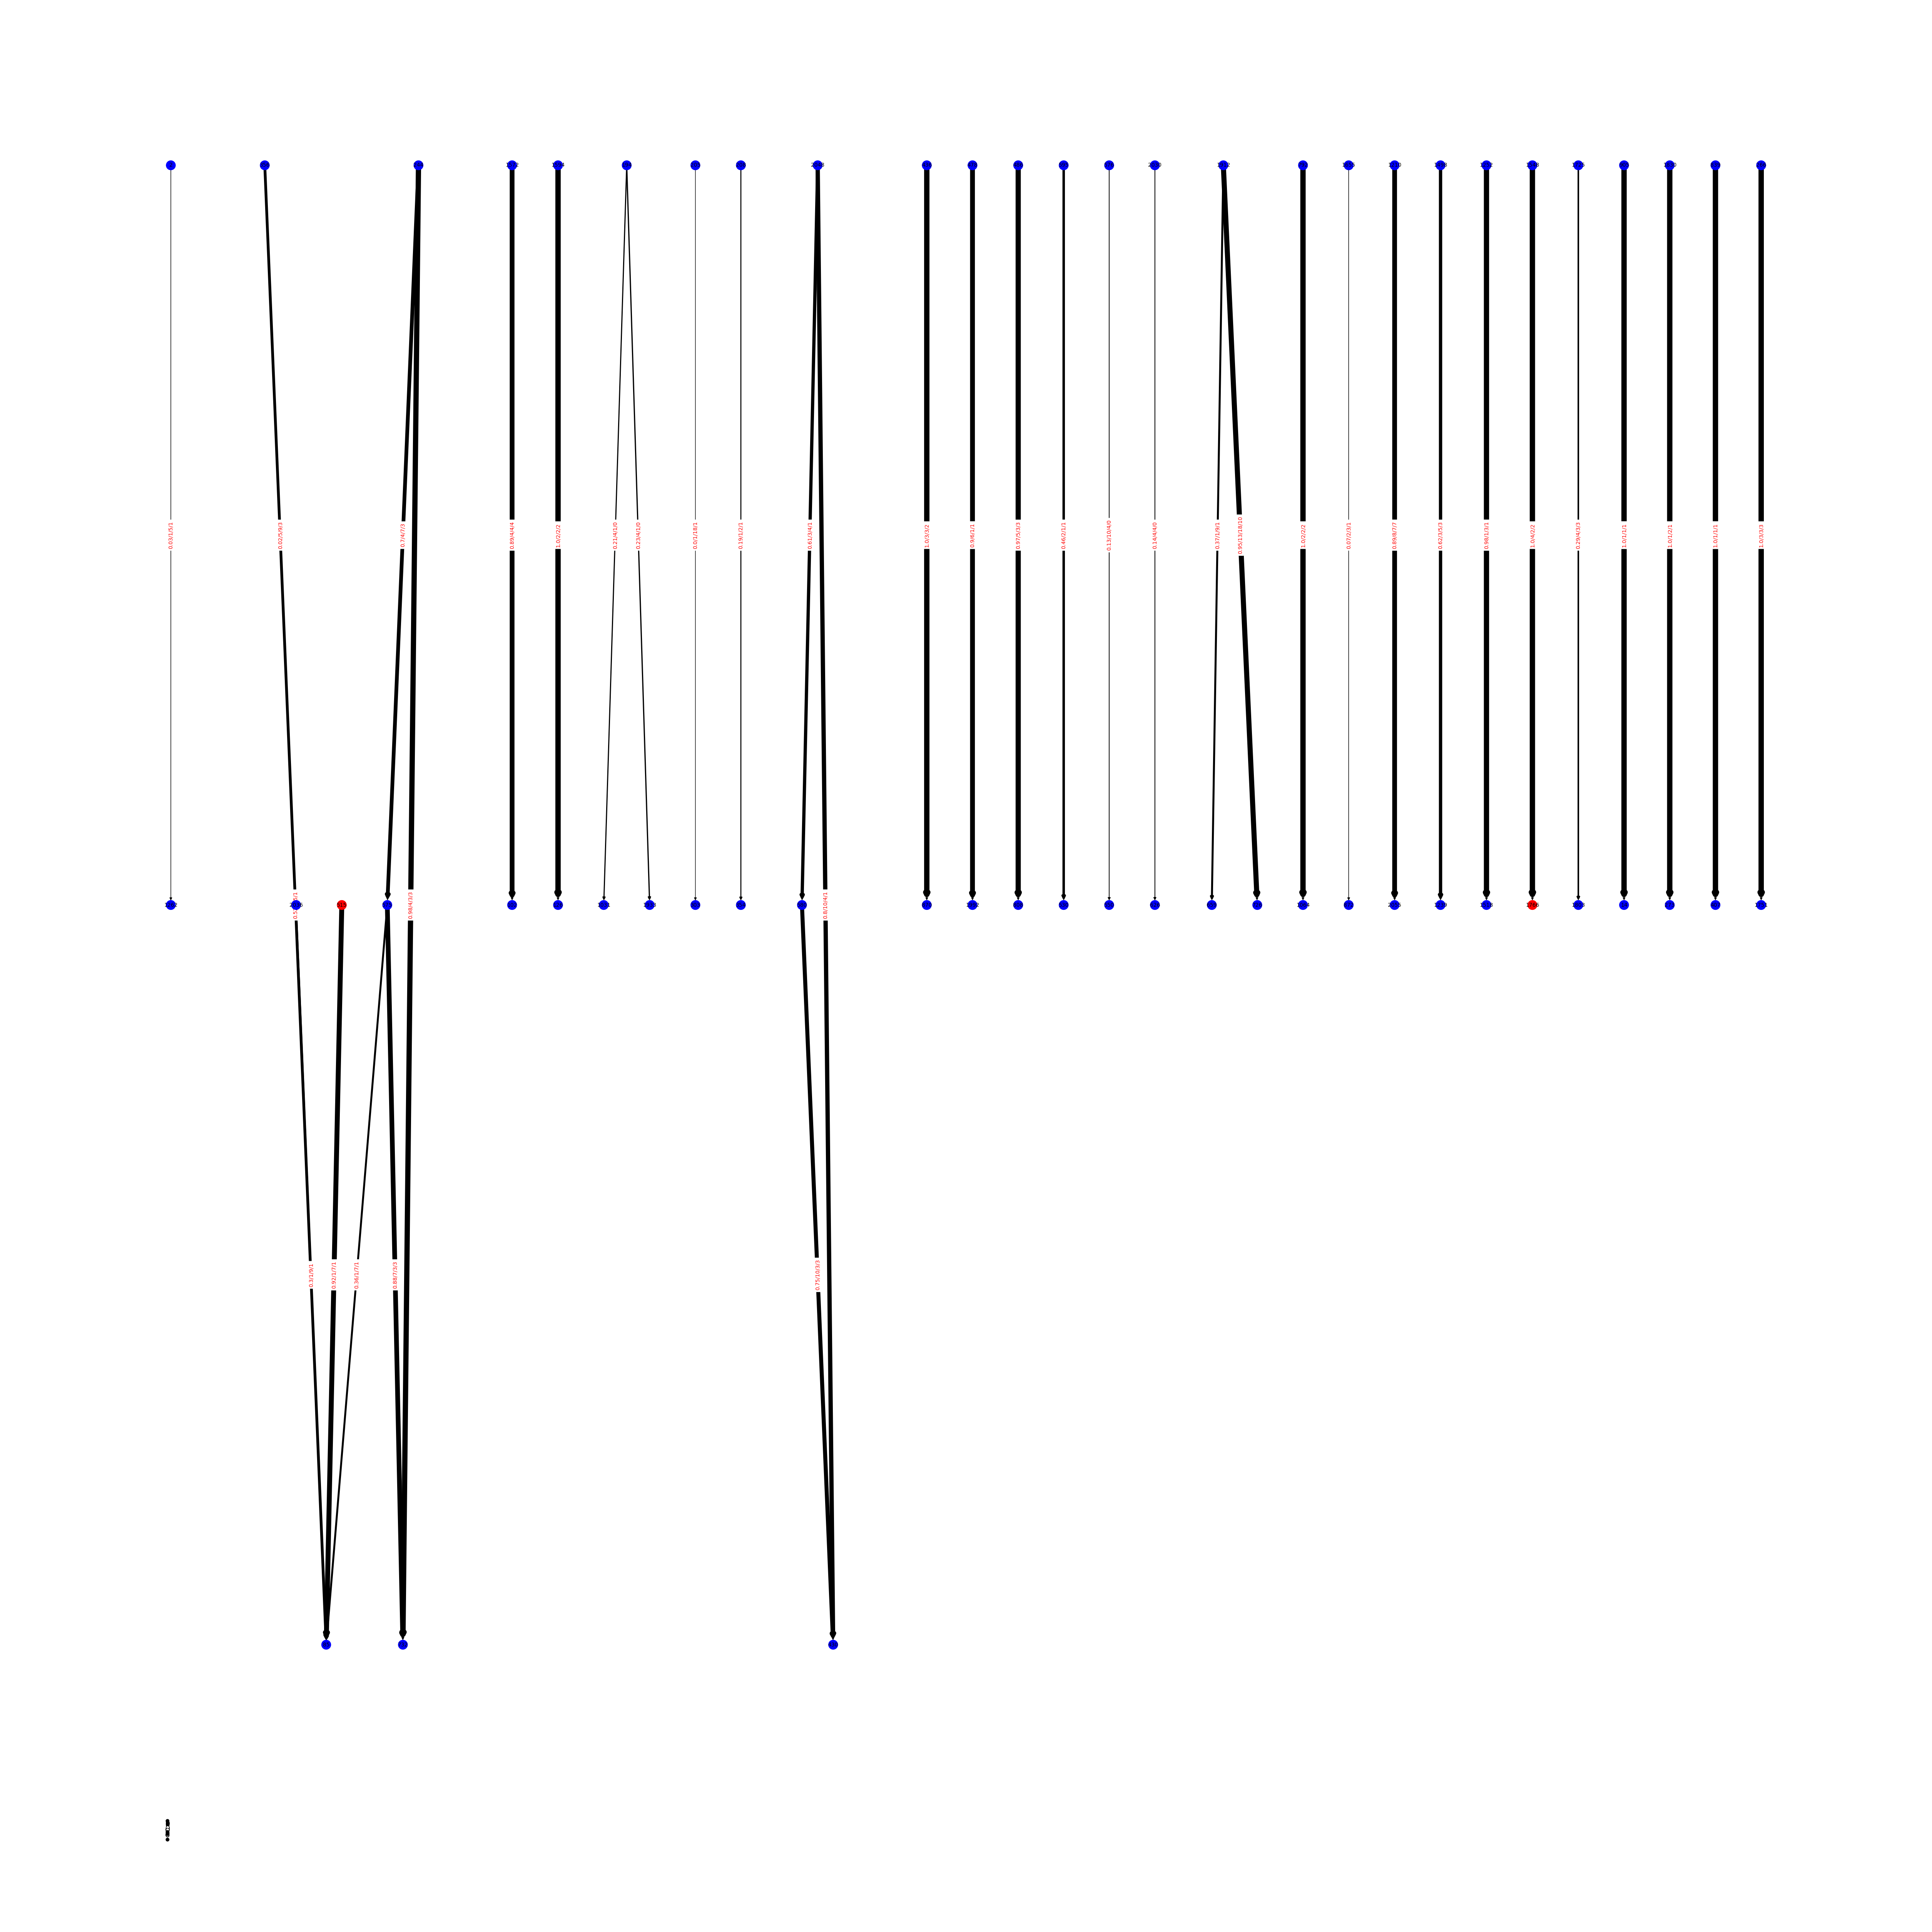

In [35]:
scatter = plt.scatter(array_being_analysed[:, 0], array_being_analysed[:, 1], edgecolors = 'black', c=kmeans.labels_, cmap='binary')

plt.show()

plt.savefig(str(tol) + '/' + str(trimming) + '-clustering' + '.png')

In [36]:
harvester = len(kmeans.labels_[kmeans.labels_ == 0]) 
person = len(kmeans.labels_[kmeans.labels_ == 1]) 

print('In this dataset, there are', harvester, 'harvester type copies and', person, 'person type copies.')

In this dataset, there are 20 harvester type copies and 17 person type copies.


## Supervised learning

In [37]:
print("There are", len(x['Labels'][x['Labels'] == 1]), "1's and", len(x['Labels'][x['Labels'] == 0]), "0's as labels.")
prop_1 = len(x['Labels'][x['Labels'] == 1]) / len(x['Labels'])
prop_0 = len(x['Labels'][x['Labels'] == 0]) / len(x['Labels'])
print("The proportion of 1's and 0's is, repectively:", prop_1, prop_0)

There are 17 1's and 20 0's as labels.
The proportion of 1's and 0's is, repectively: 0.4594594594594595 0.5405405405405406


In [38]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

class_weights = {}
class_weights[0] = prop_0
class_weights[1] = prop_1

print(class_weights)

NUM_CV = 10

X = scaled_x
y = x['Labels']

C = np.linspace(-5, 11, 9)
C = [pow(2, i) for i in C]
gamma = np.linspace(-1, 15, 9)
gamma = [pow(2, i) for i in gamma]

# Set up possible values of parameters to optimize over
p_grid = {"C": C,  #2^[-5, -3, ... , 10]
          "gamma": gamma} #2^[-1, 1, ... , 15]

svc = svm.SVC(kernel='linear', class_weight=class_weights)
clf = GridSearchCV(svc, param_grid=p_grid, cv=NUM_CV, iid=False)
print(clf)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=NUM_CV)

{0: 0.5405405405405406, 1: 0.4594594594594595}
GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200,
                           class_weight={0: 0.5405405405405406,
                                         1: 0.4594594594594595},
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': [0.03125, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0,
                               512.0, 2048.0],
                         'gamma': [0.5, 2.0, 8.0, 32.0, 128.0, 512.0, 2048.0,
                                   8192.0, 32768.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


In [39]:
print("This model can differentiate harvesters (0) from collaborators (1) with an accuracy and standard \
deviation of, respectively: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

This model can differentiate harvesters (0) from collaborators (1) with an accuracy and standard deviation of, respectively: 1.00 (+/- 0.00)


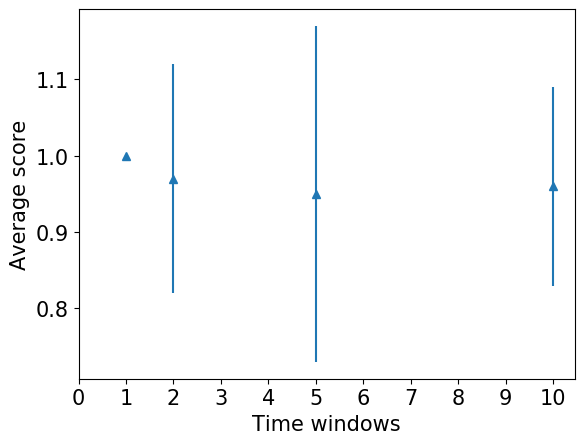

In [50]:
x = np.array([1, 2, 5, 10])
y = np.array([1, 0.97, 0.95, 0.96]) # Effectively y = x**2
e = np.array([0, 0.15, 0.22, 0.13])

plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.xlabel('Time windows', fontsize=15)
plt.ylabel('Average score', fontsize=15)

plt.yticks(fontsize=15)
plt.xticks(np.linspace(0, 10, 11), fontsize=15)

plt.show()